# Models Comparison for TinyML

In [15]:
# Load libraries
import numpy as np
from numpy import arange
import pickle
#
import matplotlib.pyplot as plt

#
import pandas as pd
from pandas import read_csv

from sklearn.metrics import confusion_matrix,  classification_report, f1_score
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential, Model 
from keras.layers import Dense, Input, concatenate, Activation, Dropout
from keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

import tensorflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from micromlgen import port
import tinymlgen as tiny

import warnings
import seaborn as sbs
import sys

warnings.filterwarnings('ignore')

In [16]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tensorflow.random.set_seed(RANDOM_SEED)
np.set_printoptions(threshold=sys.maxsize)
tasks = ["2Labels", "3Labels", "4Labels", "5Labels"]
choosenIndex = 0

In [17]:
with open('data/X2.pkl', 'rb') as f:
    X = pickle.load(f)

with open('data/y2.pkl', 'rb') as f:
    y = pickle.load(f)

In [18]:
n_labels = 2 + choosenIndex
samples = 150
X = X[:n_labels*samples]
y = y[:n_labels*samples]
labels = np.unique(y)

In [19]:
classes = np.unique(y).tolist()
for i in range(len(classes)):
    y = np.where(y==classes[i], i, y)

In [20]:
y = np.array([int(el) for el in y])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED)
print(X_test)
print(y_test.shape)
scaler = RobustScaler()


[[1681.61 1793.95 1284.47  688.31  831.26  326.18  198.29  185.82   80.8
   120.12   73.22  118.04  192.28  194.27  315.88  310.18  335.88  414.11
   434.93  338.98  266.97  308.11  283.55  275.53  331.38  402.95  195.61
   377.56  174.6   100.59   93.3   162.98]
 [1146.01 1995.76 2296.28 2049.1  1824.41 1645.48 1476.07 1203.49 1152.23
   550.19  211.05  243.95  253.25  235.52  245.71  153.87  158.24  123.83
   103.55   39.04   46.68   34.29   51.92   31.7   120.94   75.64   96.03
    42.45   76.5   174.95  163.42  119.99]
 [1473.04 2135.31 1910.89 2114.22 1961.72 2522.15 2194.22 1581.67 2193.98
  2572.83 2253.28  680.13  309.38  236.37  120.15  137.79   69.64   63.77
    24.43   25.14  101.39   68.47   91.94   92.24   87.96  114.5   130.06
   123.63  152.26  102.42  157.31  113.33]
 [1649.02 1464.62  913.96  928.75  401.29  260.13  285.68  253.72  314.22
   385.07  386.46  462.89  524.19  468.13  402.8   323.76  295.94  197.64
    98.44   62.97  229.19  165.9   269.29  215.75  240.68 

NameError: name 'RobustScaler' is not defined

In [22]:
y_test

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1])

In [23]:
X_test.shape

(60, 32)

## Model Spotting

In [24]:
# Test options and evaluation metric
num_folds = 10
seed = 42
scoring = 'f1_macro'

In [25]:
# Spot-Check Algorithms
models = []

#models.append(('XGB', XGBClassifier(random_state=seed)))
models.append(('GNB', GaussianNB(var_smoothing=2e-9)))
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('CART' , DecisionTreeClassifier(random_state=seed)))
models.append(('SVC' , SVC(gamma=0.05, random_state=seed)))
if n_labels == 5:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=250, 
                                                           max_features=9, criterion='entropy', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))

else:
    models.append(('RF', RandomForestClassifier(random_state=RANDOM_SEED, n_estimators=50, 
                                                           max_features=5, criterion='gini', max_depth=None,
                                                           min_samples_split=4, min_samples_leaf=1
                                                          )))


In [26]:
# Cross Validation
results = []
names = []
for name, model in models:
    # Dividere dati in n = num_folds
    kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = np.array([])
    for train_idx, test_idx, in kf.split(X_train, y_train):
        X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
        X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
        model.fit(X_cross_train, y_cross_train)  
        y_pred = model.predict(X_cross_test)
        f1s = f1_score(y_cross_test, y_pred, average="weighted")
        cv_results = np.append(cv_results, [f1s])
    results.append(cv_results)
    names.append(name)
    #msg = "%s - %f - %f" % (name, cv_results.mean(), cv_results.std())
    msg = "{} - {:.2f} {:.2f}".format(name, cv_results.mean(), cv_results.std()).replace('.', ',')
    print(msg)

GNB - 0,61 0,08
LR - 0,63 0,11
CART - 0,75 0,11
SVC - 0,33 0,00
RF - 0,83 0,05


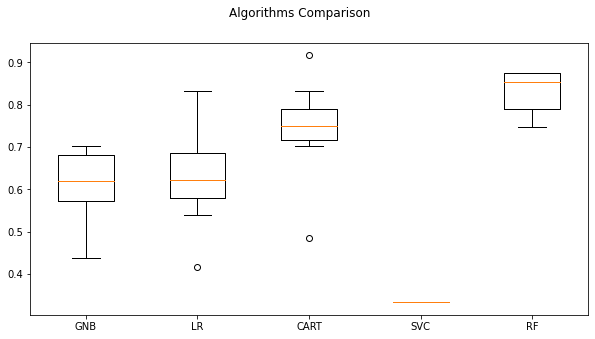

In [27]:
# Compare Algorithms
fig = plt.figure(figsize=(10,5))
fig.suptitle('Algorithms Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

Valutazione dei migliori algoritmi su test

## Valutazione modelli sul Test Set

In [28]:
def classification_report_csv(report, model_name):
    report_data = []
    lines = report.split('\n')
    index = 0
    row = lines[-4].split('    ')
    accuracy = row[-2] if choosenIndex > 1 else row[-3]
    for line in lines[2:-5]:
        row = {}
        row_data = line.split('      ')
        row['class'] = labels[index]
        row['precision'] = float(row_data[2]) 
        row['recall'] = float(row_data[3]) 
        row['f1_score'] = float(row_data[4])
        row['accuracy'] = accuracy
        report_data.append(row)
        index += 1
    dataframe = pd.DataFrame.from_dict(report_data)
    dataframe.to_csv(tasks[choosenIndex] + "/classificationReports/" +'report' + model_name +  '.csv', index = False)
    
for name, model in models:
    model.fit(X_train,  y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    print(f"Model {name}: ")
    report = classification_report(y_test, pred_test)
    print(report)
    classification_report_csv(report, name)
    print("-------------------------------------------------------------")

Model GNB: 
              precision    recall  f1-score   support

           0       0.70      0.87      0.78        30
           1       0.83      0.63      0.72        30

    accuracy                           0.75        60
   macro avg       0.76      0.75      0.75        60
weighted avg       0.76      0.75      0.75        60

-------------------------------------------------------------
Model LR: 
              precision    recall  f1-score   support

           0       0.67      0.67      0.67        30
           1       0.67      0.67      0.67        30

    accuracy                           0.67        60
   macro avg       0.67      0.67      0.67        60
weighted avg       0.67      0.67      0.67        60

-------------------------------------------------------------
Model CART: 
              precision    recall  f1-score   support

           0       0.79      0.77      0.78        30
           1       0.77      0.80      0.79        30

    accuracy          

## Valutazione Inferance Rate medio (|X_test| = 40)

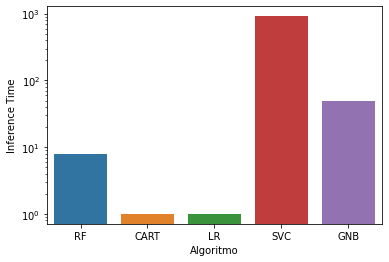

In [29]:
csv = read_csv("InfTimeReport.csv")
g = sbs.barplot(x=csv['Algoritmo'], y=csv['InfTime'])
g.set_yscale("log")
plt.ylabel("Inference Time")
plt.show()

## Memoria occupata

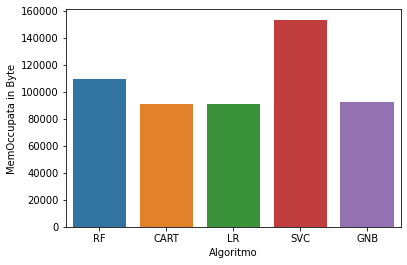

In [30]:
csv = read_csv("MemOccupationReport.csv")
sbs.barplot(x=csv['Algoritmo'], y=csv['MemOccupata2'])
plt.ylabel("MemOccupata in Byte")
plt.show()

# Neural Network

In [31]:
EPOCHS = 1000 #if labels == 3 else 500
BATCH_SIZE = 4
learn_rate = 0.00007 if labels == 3 else 0.0001
def getNetwork():
    model = Sequential(name="Sequential-NN")
    model.add(layers.Dense(X.shape[1], activation='relu', input_shape=(X.shape[1],)))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(np.unique(y).size, activation='softmax'))
    opt = Adam(learning_rate=learn_rate)
    # SGB
    model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

## Cross Validation NN

In [160]:
num_folds = 10

kf = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
cv_results = np.array([])
for train_idx, test_idx, in kf.split(X_train, y_train):
    X_cross_train, y_cross_train = X_train[train_idx], y_train[train_idx]
    X_cross_train = scaler.fit_transform(X_cross_train)
    X_cross_test, y_cross_test = X_train[test_idx], y_train[test_idx]
    X_cross_test = scaler.transform(X_cross_test)
    model = getNetwork()
    model.fit(X_cross_train, y_cross_train, epochs=EPOCHS, batch_size=BATCH_SIZE)  
    y_pred = model.predict(X_cross_test)
    predictions_categorical = np.argmax(y_pred, axis=1)
    f1s = f1_score(y_cross_test, predictions_categorical, average="weighted")
    cv_results = np.append(cv_results, [f1s])

print(f'Average score of Cross Validation: {cv_results.mean()}')

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 32)                1056      
_________________________________________________________________
dropout_22 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_34 (Dense)             (None, 256)               8448      
_________________________________________________________________
dropout_23 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 5)                 1285      
Total params: 10,789
Trainable params: 10,789
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
135/135 [==============================] - 0s 467us/step - loss: 1.6556 - accuracy: 0.1796
Epoch 2/100

KeyboardInterrupt: 

## Train and Test

In [32]:
model = getNetwork()
history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.25)

Model: "Sequential-NN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                1056      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               8448      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 514       
Total params: 10,018
Trainable params: 10,018
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
45/45 [==============================] - 0s 2ms/step - loss: 152.1569 - accuracy: 0.5056 - val_loss: 4

Epoch 50/1000
45/45 [==============================] - 0s 723us/step - loss: 30.6886 - accuracy: 0.6333 - val_loss: 18.9054 - val_accuracy: 0.6167
Epoch 51/1000
45/45 [==============================] - 0s 720us/step - loss: 26.8174 - accuracy: 0.6722 - val_loss: 21.7681 - val_accuracy: 0.6333
Epoch 52/1000
45/45 [==============================] - 0s 717us/step - loss: 21.9292 - accuracy: 0.6944 - val_loss: 20.0509 - val_accuracy: 0.6167
Epoch 53/1000
45/45 [==============================] - 0s 712us/step - loss: 21.8882 - accuracy: 0.6611 - val_loss: 18.2784 - val_accuracy: 0.6167
Epoch 54/1000
45/45 [==============================] - 0s 721us/step - loss: 18.9327 - accuracy: 0.7111 - val_loss: 16.0840 - val_accuracy: 0.6333
Epoch 55/1000
45/45 [==============================] - 0s 724us/step - loss: 25.5094 - accuracy: 0.6833 - val_loss: 16.3577 - val_accuracy: 0.6333
Epoch 56/1000
45/45 [==============================] - 0s 792us/step - loss: 18.4951 - accuracy: 0.7056 - val_loss: 14

Epoch 106/1000
45/45 [==============================] - 0s 701us/step - loss: 13.2826 - accuracy: 0.7222 - val_loss: 9.7361 - val_accuracy: 0.7000
Epoch 107/1000
45/45 [==============================] - 0s 696us/step - loss: 8.9678 - accuracy: 0.7333 - val_loss: 10.6892 - val_accuracy: 0.6667
Epoch 108/1000
45/45 [==============================] - 0s 712us/step - loss: 6.4462 - accuracy: 0.7167 - val_loss: 9.9637 - val_accuracy: 0.7000
Epoch 109/1000
45/45 [==============================] - 0s 727us/step - loss: 4.6670 - accuracy: 0.7389 - val_loss: 9.9650 - val_accuracy: 0.6667
Epoch 110/1000
45/45 [==============================] - 0s 713us/step - loss: 8.1760 - accuracy: 0.7333 - val_loss: 10.3237 - val_accuracy: 0.6833
Epoch 111/1000
45/45 [==============================] - 0s 732us/step - loss: 7.3885 - accuracy: 0.8111 - val_loss: 10.0665 - val_accuracy: 0.6667
Epoch 112/1000
45/45 [==============================] - 0s 741us/step - loss: 8.1360 - accuracy: 0.7000 - val_loss: 8.70

45/45 [==============================] - 0s 730us/step - loss: 2.6223 - accuracy: 0.7500 - val_loss: 5.8686 - val_accuracy: 0.6500
Epoch 163/1000
45/45 [==============================] - 0s 715us/step - loss: 2.3298 - accuracy: 0.7944 - val_loss: 6.5667 - val_accuracy: 0.6333
Epoch 164/1000
45/45 [==============================] - 0s 736us/step - loss: 3.0661 - accuracy: 0.7056 - val_loss: 6.9262 - val_accuracy: 0.6500
Epoch 165/1000
45/45 [==============================] - 0s 737us/step - loss: 2.5533 - accuracy: 0.7444 - val_loss: 6.5845 - val_accuracy: 0.6333
Epoch 166/1000
45/45 [==============================] - 0s 741us/step - loss: 1.8518 - accuracy: 0.7889 - val_loss: 5.8614 - val_accuracy: 0.6333
Epoch 167/1000
45/45 [==============================] - 0s 709us/step - loss: 2.0245 - accuracy: 0.7778 - val_loss: 5.4000 - val_accuracy: 0.6167
Epoch 168/1000
45/45 [==============================] - 0s 730us/step - loss: 4.1140 - accuracy: 0.7611 - val_loss: 5.6954 - val_accuracy: 

45/45 [==============================] - 0s 735us/step - loss: 1.6079 - accuracy: 0.7278 - val_loss: 3.8216 - val_accuracy: 0.6000
Epoch 219/1000
45/45 [==============================] - 0s 743us/step - loss: 0.8428 - accuracy: 0.7722 - val_loss: 4.0747 - val_accuracy: 0.6000
Epoch 220/1000
45/45 [==============================] - 0s 717us/step - loss: 1.3586 - accuracy: 0.7500 - val_loss: 3.5798 - val_accuracy: 0.6167
Epoch 221/1000
45/45 [==============================] - 0s 753us/step - loss: 1.5041 - accuracy: 0.7278 - val_loss: 3.5958 - val_accuracy: 0.6000
Epoch 222/1000
45/45 [==============================] - 0s 809us/step - loss: 1.1947 - accuracy: 0.7500 - val_loss: 3.6423 - val_accuracy: 0.6000
Epoch 223/1000
45/45 [==============================] - 0s 713us/step - loss: 1.2566 - accuracy: 0.7778 - val_loss: 3.8934 - val_accuracy: 0.6000
Epoch 224/1000
45/45 [==============================] - 0s 741us/step - loss: 1.1646 - accuracy: 0.7833 - val_loss: 3.7153 - val_accuracy: 

45/45 [==============================] - 0s 753us/step - loss: 0.7946 - accuracy: 0.7667 - val_loss: 3.4794 - val_accuracy: 0.5833
Epoch 275/1000
45/45 [==============================] - 0s 768us/step - loss: 0.5988 - accuracy: 0.7778 - val_loss: 3.3529 - val_accuracy: 0.6000
Epoch 276/1000
45/45 [==============================] - 0s 754us/step - loss: 0.6060 - accuracy: 0.7833 - val_loss: 3.0638 - val_accuracy: 0.5833
Epoch 277/1000
45/45 [==============================] - 0s 736us/step - loss: 0.5276 - accuracy: 0.8222 - val_loss: 2.9367 - val_accuracy: 0.5667
Epoch 278/1000
45/45 [==============================] - 0s 727us/step - loss: 0.8431 - accuracy: 0.7722 - val_loss: 2.6650 - val_accuracy: 0.5833
Epoch 279/1000
45/45 [==============================] - 0s 743us/step - loss: 0.4512 - accuracy: 0.8111 - val_loss: 2.8345 - val_accuracy: 0.5833
Epoch 280/1000
45/45 [==============================] - 0s 739us/step - loss: 0.5444 - accuracy: 0.7833 - val_loss: 2.9983 - val_accuracy: 

45/45 [==============================] - 0s 720us/step - loss: 0.3980 - accuracy: 0.7889 - val_loss: 3.4795 - val_accuracy: 0.6000
Epoch 331/1000
45/45 [==============================] - 0s 737us/step - loss: 0.3821 - accuracy: 0.8222 - val_loss: 3.3563 - val_accuracy: 0.6167
Epoch 332/1000
45/45 [==============================] - 0s 726us/step - loss: 0.5371 - accuracy: 0.8278 - val_loss: 3.2669 - val_accuracy: 0.6167
Epoch 333/1000
45/45 [==============================] - 0s 705us/step - loss: 0.4020 - accuracy: 0.8222 - val_loss: 3.2668 - val_accuracy: 0.6167
Epoch 334/1000
45/45 [==============================] - 0s 750us/step - loss: 0.4097 - accuracy: 0.8000 - val_loss: 3.3653 - val_accuracy: 0.6167
Epoch 335/1000
45/45 [==============================] - 0s 730us/step - loss: 0.3468 - accuracy: 0.8333 - val_loss: 3.2946 - val_accuracy: 0.5833
Epoch 336/1000
45/45 [==============================] - 0s 765us/step - loss: 0.3698 - accuracy: 0.8167 - val_loss: 3.4165 - val_accuracy: 

45/45 [==============================] - 0s 709us/step - loss: 0.5396 - accuracy: 0.8056 - val_loss: 2.7652 - val_accuracy: 0.5667
Epoch 387/1000
45/45 [==============================] - 0s 752us/step - loss: 0.3627 - accuracy: 0.8167 - val_loss: 3.0233 - val_accuracy: 0.5667
Epoch 388/1000
45/45 [==============================] - 0s 855us/step - loss: 0.3494 - accuracy: 0.8222 - val_loss: 3.0354 - val_accuracy: 0.5667
Epoch 389/1000
45/45 [==============================] - 0s 760us/step - loss: 0.3293 - accuracy: 0.8444 - val_loss: 3.2028 - val_accuracy: 0.5833
Epoch 390/1000
45/45 [==============================] - 0s 754us/step - loss: 0.4238 - accuracy: 0.8000 - val_loss: 3.1602 - val_accuracy: 0.5833
Epoch 391/1000
45/45 [==============================] - 0s 796us/step - loss: 0.3962 - accuracy: 0.7944 - val_loss: 2.9593 - val_accuracy: 0.5833
Epoch 392/1000
45/45 [==============================] - 0s 731us/step - loss: 0.3784 - accuracy: 0.8056 - val_loss: 3.0204 - val_accuracy: 

45/45 [==============================] - 0s 736us/step - loss: 0.3542 - accuracy: 0.8222 - val_loss: 3.4862 - val_accuracy: 0.5833
Epoch 443/1000
45/45 [==============================] - 0s 749us/step - loss: 0.3828 - accuracy: 0.7944 - val_loss: 3.7150 - val_accuracy: 0.6000
Epoch 444/1000
45/45 [==============================] - 0s 716us/step - loss: 0.4388 - accuracy: 0.7778 - val_loss: 3.8344 - val_accuracy: 0.6000
Epoch 445/1000
45/45 [==============================] - 0s 760us/step - loss: 0.3768 - accuracy: 0.7944 - val_loss: 3.3623 - val_accuracy: 0.5667
Epoch 446/1000
45/45 [==============================] - 0s 742us/step - loss: 0.3860 - accuracy: 0.8056 - val_loss: 3.0541 - val_accuracy: 0.5833
Epoch 447/1000
45/45 [==============================] - 0s 738us/step - loss: 0.3878 - accuracy: 0.8000 - val_loss: 3.0405 - val_accuracy: 0.6000
Epoch 448/1000
45/45 [==============================] - 0s 729us/step - loss: 0.3576 - accuracy: 0.8222 - val_loss: 3.1731 - val_accuracy: 

45/45 [==============================] - 0s 747us/step - loss: 0.3681 - accuracy: 0.8167 - val_loss: 3.5882 - val_accuracy: 0.6000
Epoch 499/1000
45/45 [==============================] - 0s 752us/step - loss: 0.3347 - accuracy: 0.8333 - val_loss: 3.6182 - val_accuracy: 0.6000
Epoch 500/1000
45/45 [==============================] - 0s 716us/step - loss: 0.4126 - accuracy: 0.7833 - val_loss: 3.4776 - val_accuracy: 0.5833
Epoch 501/1000
45/45 [==============================] - 0s 732us/step - loss: 0.3671 - accuracy: 0.8111 - val_loss: 3.7511 - val_accuracy: 0.5667
Epoch 502/1000
45/45 [==============================] - 0s 727us/step - loss: 0.3638 - accuracy: 0.8333 - val_loss: 3.7896 - val_accuracy: 0.6000
Epoch 503/1000
45/45 [==============================] - 0s 727us/step - loss: 0.3743 - accuracy: 0.8111 - val_loss: 3.9702 - val_accuracy: 0.6000
Epoch 504/1000
45/45 [==============================] - 0s 721us/step - loss: 0.3675 - accuracy: 0.8056 - val_loss: 4.0864 - val_accuracy: 

45/45 [==============================] - 0s 742us/step - loss: 0.3598 - accuracy: 0.8222 - val_loss: 4.0484 - val_accuracy: 0.5833
Epoch 555/1000
45/45 [==============================] - 0s 747us/step - loss: 0.3383 - accuracy: 0.8278 - val_loss: 4.1102 - val_accuracy: 0.5833
Epoch 556/1000
45/45 [==============================] - 0s 762us/step - loss: 0.3492 - accuracy: 0.8222 - val_loss: 4.1452 - val_accuracy: 0.5833
Epoch 557/1000
45/45 [==============================] - 0s 750us/step - loss: 0.3254 - accuracy: 0.8389 - val_loss: 4.1809 - val_accuracy: 0.5833
Epoch 558/1000
45/45 [==============================] - 0s 754us/step - loss: 0.3733 - accuracy: 0.8056 - val_loss: 4.2151 - val_accuracy: 0.5833
Epoch 559/1000
45/45 [==============================] - 0s 718us/step - loss: 0.4064 - accuracy: 0.8167 - val_loss: 4.3481 - val_accuracy: 0.5833
Epoch 560/1000
45/45 [==============================] - 0s 762us/step - loss: 0.3308 - accuracy: 0.8333 - val_loss: 4.4162 - val_accuracy: 

45/45 [==============================] - 0s 742us/step - loss: 0.2901 - accuracy: 0.8611 - val_loss: 4.2536 - val_accuracy: 0.5667
Epoch 611/1000
45/45 [==============================] - 0s 741us/step - loss: 0.3275 - accuracy: 0.8389 - val_loss: 4.2545 - val_accuracy: 0.5667
Epoch 612/1000
45/45 [==============================] - 0s 764us/step - loss: 0.3347 - accuracy: 0.8333 - val_loss: 4.3544 - val_accuracy: 0.5667
Epoch 613/1000
45/45 [==============================] - 0s 737us/step - loss: 0.3550 - accuracy: 0.8222 - val_loss: 4.2268 - val_accuracy: 0.5667
Epoch 614/1000
45/45 [==============================] - 0s 751us/step - loss: 0.4091 - accuracy: 0.8056 - val_loss: 3.9231 - val_accuracy: 0.6000
Epoch 615/1000
45/45 [==============================] - 0s 720us/step - loss: 0.4014 - accuracy: 0.7889 - val_loss: 4.0953 - val_accuracy: 0.5833
Epoch 616/1000
45/45 [==============================] - 0s 748us/step - loss: 0.3038 - accuracy: 0.8444 - val_loss: 4.1926 - val_accuracy: 

45/45 [==============================] - 0s 751us/step - loss: 0.3622 - accuracy: 0.7944 - val_loss: 4.3381 - val_accuracy: 0.5667
Epoch 667/1000
45/45 [==============================] - 0s 733us/step - loss: 0.3591 - accuracy: 0.8056 - val_loss: 4.3623 - val_accuracy: 0.5667
Epoch 668/1000
45/45 [==============================] - 0s 695us/step - loss: 0.3545 - accuracy: 0.7944 - val_loss: 4.3445 - val_accuracy: 0.5667
Epoch 669/1000
45/45 [==============================] - 0s 712us/step - loss: 0.3139 - accuracy: 0.8389 - val_loss: 4.4127 - val_accuracy: 0.5667
Epoch 670/1000
45/45 [==============================] - 0s 735us/step - loss: 0.3266 - accuracy: 0.8278 - val_loss: 4.0646 - val_accuracy: 0.5833
Epoch 671/1000
45/45 [==============================] - 0s 752us/step - loss: 0.3825 - accuracy: 0.8167 - val_loss: 4.3778 - val_accuracy: 0.5833
Epoch 672/1000
45/45 [==============================] - 0s 727us/step - loss: 0.3924 - accuracy: 0.7833 - val_loss: 4.4319 - val_accuracy: 

45/45 [==============================] - 0s 763us/step - loss: 0.3173 - accuracy: 0.8333 - val_loss: 4.0633 - val_accuracy: 0.5833
Epoch 723/1000
45/45 [==============================] - 0s 731us/step - loss: 0.3602 - accuracy: 0.7944 - val_loss: 4.0054 - val_accuracy: 0.5833
Epoch 724/1000
45/45 [==============================] - 0s 714us/step - loss: 0.3006 - accuracy: 0.8500 - val_loss: 4.2747 - val_accuracy: 0.5833
Epoch 725/1000
45/45 [==============================] - 0s 721us/step - loss: 0.3580 - accuracy: 0.8111 - val_loss: 4.5637 - val_accuracy: 0.5833
Epoch 726/1000
45/45 [==============================] - 0s 750us/step - loss: 0.3548 - accuracy: 0.8111 - val_loss: 4.3220 - val_accuracy: 0.5833
Epoch 727/1000
45/45 [==============================] - 0s 736us/step - loss: 0.3524 - accuracy: 0.8111 - val_loss: 4.2164 - val_accuracy: 0.5833
Epoch 728/1000
45/45 [==============================] - 0s 749us/step - loss: 0.3473 - accuracy: 0.8111 - val_loss: 4.2422 - val_accuracy: 

45/45 [==============================] - 0s 734us/step - loss: 0.4580 - accuracy: 0.7889 - val_loss: 4.3675 - val_accuracy: 0.5667
Epoch 779/1000
45/45 [==============================] - 0s 688us/step - loss: 0.3680 - accuracy: 0.8000 - val_loss: 4.1617 - val_accuracy: 0.5667
Epoch 780/1000
45/45 [==============================] - 0s 737us/step - loss: 0.3038 - accuracy: 0.8500 - val_loss: 4.1923 - val_accuracy: 0.5667
Epoch 781/1000
45/45 [==============================] - 0s 724us/step - loss: 0.3497 - accuracy: 0.8278 - val_loss: 4.2953 - val_accuracy: 0.5667
Epoch 782/1000
45/45 [==============================] - 0s 742us/step - loss: 0.3518 - accuracy: 0.8111 - val_loss: 4.3287 - val_accuracy: 0.5667
Epoch 783/1000
45/45 [==============================] - 0s 763us/step - loss: 0.3212 - accuracy: 0.8444 - val_loss: 4.3566 - val_accuracy: 0.5667
Epoch 784/1000
45/45 [==============================] - 0s 751us/step - loss: 0.3454 - accuracy: 0.8222 - val_loss: 4.3557 - val_accuracy: 

45/45 [==============================] - 0s 737us/step - loss: 0.3376 - accuracy: 0.8389 - val_loss: 4.8981 - val_accuracy: 0.5667
Epoch 835/1000
45/45 [==============================] - 0s 730us/step - loss: 0.3460 - accuracy: 0.8111 - val_loss: 4.8601 - val_accuracy: 0.5667
Epoch 836/1000
45/45 [==============================] - 0s 741us/step - loss: 0.2987 - accuracy: 0.8500 - val_loss: 4.8300 - val_accuracy: 0.5667
Epoch 837/1000
45/45 [==============================] - 0s 733us/step - loss: 0.4052 - accuracy: 0.8333 - val_loss: 4.8988 - val_accuracy: 0.5667
Epoch 838/1000
45/45 [==============================] - 0s 743us/step - loss: 0.3351 - accuracy: 0.8222 - val_loss: 4.6238 - val_accuracy: 0.5667
Epoch 839/1000
45/45 [==============================] - 0s 699us/step - loss: 0.3400 - accuracy: 0.8167 - val_loss: 4.7309 - val_accuracy: 0.5667
Epoch 840/1000
45/45 [==============================] - 0s 700us/step - loss: 0.3422 - accuracy: 0.8167 - val_loss: 4.9894 - val_accuracy: 

45/45 [==============================] - 0s 724us/step - loss: 0.3404 - accuracy: 0.8167 - val_loss: 5.4339 - val_accuracy: 0.5500
Epoch 891/1000
45/45 [==============================] - 0s 713us/step - loss: 0.3323 - accuracy: 0.8500 - val_loss: 5.4068 - val_accuracy: 0.5500
Epoch 892/1000
45/45 [==============================] - 0s 734us/step - loss: 0.2830 - accuracy: 0.8722 - val_loss: 5.0517 - val_accuracy: 0.5500
Epoch 893/1000
45/45 [==============================] - 0s 712us/step - loss: 0.3300 - accuracy: 0.8389 - val_loss: 5.2687 - val_accuracy: 0.5500
Epoch 894/1000
45/45 [==============================] - 0s 694us/step - loss: 0.3280 - accuracy: 0.8389 - val_loss: 5.2472 - val_accuracy: 0.5500
Epoch 895/1000
45/45 [==============================] - 0s 713us/step - loss: 0.3037 - accuracy: 0.8556 - val_loss: 5.2214 - val_accuracy: 0.5500
Epoch 896/1000
45/45 [==============================] - 0s 716us/step - loss: 0.3415 - accuracy: 0.8111 - val_loss: 5.2461 - val_accuracy: 

45/45 [==============================] - 0s 722us/step - loss: 0.2969 - accuracy: 0.8500 - val_loss: 4.4060 - val_accuracy: 0.5833
Epoch 947/1000
45/45 [==============================] - 0s 749us/step - loss: 0.3391 - accuracy: 0.8556 - val_loss: 4.8709 - val_accuracy: 0.5833
Epoch 948/1000
45/45 [==============================] - 0s 745us/step - loss: 0.3310 - accuracy: 0.8278 - val_loss: 4.8388 - val_accuracy: 0.5833
Epoch 949/1000
45/45 [==============================] - 0s 714us/step - loss: 0.3077 - accuracy: 0.8500 - val_loss: 4.9807 - val_accuracy: 0.5833
Epoch 950/1000
45/45 [==============================] - 0s 725us/step - loss: 0.2945 - accuracy: 0.8556 - val_loss: 5.0158 - val_accuracy: 0.5667
Epoch 951/1000
45/45 [==============================] - 0s 756us/step - loss: 0.3398 - accuracy: 0.8222 - val_loss: 5.0596 - val_accuracy: 0.5667
Epoch 952/1000
45/45 [==============================] - 0s 729us/step - loss: 0.3362 - accuracy: 0.8389 - val_loss: 4.9970 - val_accuracy: 

In [33]:
pred_test = model.predict(X_test)
predictions_categorical = np.argmax(pred_test, axis=1)
report = classification_report(y_test, predictions_categorical)
print(report)
classification_report_csv(report, "NN")

              precision    recall  f1-score   support

           0       0.77      0.67      0.71        30
           1       0.71      0.80      0.75        30

    accuracy                           0.73        60
   macro avg       0.74      0.73      0.73        60
weighted avg       0.74      0.73      0.73        60



# Export Models in C code

In [34]:
# Neural network with TinyMLGen
with open(tasks[choosenIndex] + '/exportedModels/NNmodel.h', 'w') as f:
    f.write(tiny.port(model, optimize=False))

# Classifiers with MicroMLGen
for name, model in models:
    prepath = tasks[choosenIndex] + '/exportedModels/'
    path = prepath + name + '.h'
    x = port(model, optimize=True)
    with open(path, 'w') as f:
        f.write(port(model, optimize=True))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpz0vulptc/assets
